# ISEL - CPS 
## Semestre 2022/23
# <br>
###  <center> Trabalho Prático 2 Parte B </center>
# </br>


Trabalho realizado por:
* Bárbara Jesus, numero <b> 45108 </b>
* João Fernandes, numero <b> 47478 </b>
* Duarte Afonso, numero <b> 47736 </b>

<b> Turma L33D - Docente Michele Mengucci</b>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as scisig

In [3]:
path_sons = './sons/questao1/'
file = 'fonte_mov.wav'
Fs, data = wav.read(path_sons + file)

In [4]:
def getAudioAng(som, Fs):
    canal_L = np.asarray(som[:, 0], dtype = np.int64)
    canal_R = np.asarray(som[:, 1], dtype = np.int64)
    # Correlação entre os dois canais de audio (esquerdo e direito)
    correlacao = scisig.correlate(canal_L, canal_R, mode = 'full')
    # Delay entre os dois canais de audio (samples)
    atrasoSamples = np.argmax(correlacao) - len(canal_L) + 1
    # Delay entre os dois canais de audio (segundos)
    atrasoSec = atrasoSamples / Fs
    # Velocidade do som
    c = 343
    # Distância entre ouvidos
    d = 0.18
    # Ângulo estimado da fonte sonora
    teta_rad = np.arcsin(atrasoSec * c / d)
    teta_degrees = teta_rad / np.pi * 180
    return teta_rad, teta_degrees

/var/folders/tz/5qpxtf993w7fwm6jwsq4f_mc0000gn/T/ipykernel_23419/2311424451.py:15: RuntimeWarning: invalid value encountered in arcsin
  teta_rad = np.arcsin(atrasoSec * c / d)


(-1.4, 1.4, -1.2, 1.2)

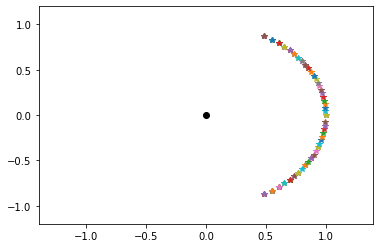

In [5]:
tempSegmento = .25
samplesSegmento = Fs * tempSegmento

angs = np.empty
coorX = np.empty
coorY = np.empty

# Distância à fonte sonora
D = 1

for i in np.arange(0, len(data[:, 0]) / samplesSegmento):
    sample_L = data[int(i*samplesSegmento):int((i+1)*samplesSegmento), 0]
    sample_R = data[int(i*samplesSegmento):int((i+1)*samplesSegmento), 1]
    sample = np.array([sample_L, sample_R])
    
    ang_rad_sample = getAudioAng(sample.T, Fs)[0]
    angs = np.append(angs, ang_rad_sample)
    coorX = np.append(coorX, D * np.cos(ang_rad_sample))
    coorY = np.append(coorY, D * np.sin(ang_rad_sample))
    
angs = angs[1:]
coorX = coorX[1:]
coorY = coorY[1:]

for i in range(len(coorX)):
    plt.plot(coorX[i], coorY[i], '*')
plt.plot(0, 0, 'ok')
plt.axis([-1.4, 1.4, -1.2, 1.2])

# Questão 2


In [6]:
path_sons = './sons/questao1/'
file = 'binaural_ITD_c_Questao1.wav'
Fs, data = wav.read(path_sons + file)

In [7]:
campo_direto = data[:, 0]

In [8]:
def campoReverb_Total(RT60, som, Fs):

    if RT60 == 0:
        return np.zeros(Fs), som
    
    n = np.arange(0, 1*Fs)
    C = 3*np.log(10/RT60)
    beta = np.random.randn(len(n))
    
    # Room Impulse Response
    RIR = beta * np.exp(-C/Fs*n)
    RIR = RIR/np.max(np.abs(RIR)) # normaliza a 1
    RIR = RIR*2**(15-1) # normaliza a int16
    
    campo_reverb = np.convolve(np.asarray(som, dtype=np.int32), np.asarray(RIR, dtype=np.int32))
    campo_reverb = campo_reverb/(2**18)
    
    if (len(som) > len(campo_reverb)):
        campo_total = campo_reverb + som[:len(campo_reverb)]
    else:
        campo_total = campo_reverb[:len(som)] + som
    
    return campo_reverb, campo_total

In [9]:
som = campo_direto

campo_reverb0, campo_total0 = campoReverb_Total(0, campo_direto, Fs)
campo_reverb5, campo_total5 = campoReverb_Total(.5, campo_direto, Fs)
campo_reverb2, campo_total2 = campoReverb_Total(2, campo_direto, Fs)
campo_reverb10, campo_total10 = campoReverb_Total(10, campo_direto, Fs)

In [10]:
wav.write('./sons/questao2/campo_direto.wav', Fs, campo_direto.astype(np.int16))
wav.write('./sons/questao2/campo_reverb0.wav', Fs, campo_reverb0.astype(np.int16))
wav.write('./sons/questao2/campo_total0.wav', Fs, campo_total0.astype(np.int16))
wav.write('./sons/questao2/campo_reverb.5.wav', Fs, campo_reverb5.astype(np.int16))
wav.write('./sons/questao2/campo_total.5.wav', Fs, campo_total5.astype(np.int16))
wav.write('./sons/questao2/campo_reverb2.wav', Fs, campo_reverb2.astype(np.int16))
wav.write('./sons/questao2/campo_total2.wav', Fs, campo_total2.astype(np.int16))
wav.write('./sons/questao2/campo_reverb10.wav', Fs, campo_reverb10.astype(np.int16))
wav.write('./sons/questao2/campo_total10.wav', Fs, campo_total10.astype(np.int16))

# Questão 3

In [141]:
path_orquestra = './sons/orquestra/'
file = '01_Kick.wav'
Fs, data = wav.read(path_orquestra + file)

/var/folders/tz/5qpxtf993w7fwm6jwsq4f_mc0000gn/T/ipykernel_23419/3408854485.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wav.read(path_orquestra + file)


In [12]:
# Função que muda a direção de uma fonte sonora de acordo com o ângulo pretendido.
# O som passado como argumento deve ser monaural e do tipo int32
# O ângulo passado deve estar entre -pi e pi (positivo para o lado esquerdo e negativo para o lado direito)
# Modos:
# direct - o som vai direto da fonte ao ouvido
# around - o som contorna a cabeça antes de chegar ao ouvido
def changeAudioSourcePos(som, Fs, angle, mode = 'direct'):
    
    # Velocidade do som
    c = 343
    # Distância entre ouvidos
    d = 0.18
    
    # Delay entre canais quando o som passa direto da fonte ao ouvido
    delay = d * np.sin(angle) / c
    if mode == 'around':
        # Delay entre canais quando o som contorna a cabeça antes de chegar ao ouvido
        delay = (d/2) * (angle + np.sin(angle)) / c

    # Delay entre canais (em amostras)
    delaySamples = abs(int(delay * Fs))
    
    canal_0 = som
    canal_1 = som
    
    for i in range(delaySamples):
        canal_0 = np.append(canal_0, 0)
        canal_1 = np.insert(canal_1, 0, 0)
    
    # Normalizar a 16 bits
    canal_0 = canal_0/(2**16)
    canal_1 = canal_1/(2**16)
    
    # Distinguir esquerda e direita
    if angle <= 0:
        result = np.array((canal_1.astype(np.int16), canal_0.astype(np.int16)))
    else:
        result = np.array((canal_0.astype(np.int16), canal_1.astype(np.int16)))
    return result.T

def changeAngHRTF(som, angle):
    path_HRTF = './HRTF/elev0/'
    HRTFname = 'H0e'+ '0' + str(abs(angle)) + 'a.wav'
    if abs(angle) < 10:
        HRTFname = 'H0e'+ '00' + str(abs(angle)) + 'a.wav'
    if abs(angle) > 99:
        HRTFname = 'H0e' + str(abs(angle)) + 'a.wav'
    Fs, hrtf = wav.read(path_HRTF + HRTFname)
    
    som = np.asarray(som, dtype=np.int32)
    hrtf = np.asarray(hrtf, dtype=np.int32)
    
    canal0 = np.convolve(som, hrtf[:, 0])
    canal1 = np.convolve(som, hrtf[:, 1])
    
    result = np.empty((2, len(canal0)), dtype = np.int32)
    
    if angle >= 0:
        result[0] = canal0 / (2**15)
        result[1] = canal1 / (2**15)
    else:
        result[1] = canal0 / (2**15)
        result[0] = canal1 / (2**15)
    
    return result.T
    
import os    

def getAudioData():
    
    path_orquestra = './sons/orquestra/'
    dataArr = []

    for i in os.listdir(path_orquestra):
        Fs, data = wav.read(path_orquestra + i)
        dataArr.append(data)
        
    return np.array(dataArr)

In [13]:
angles = [0, 45, 90, 135, -45, -90, -180]
audios = getAudioData()

for i in range(len(angles)):
    destination = './sons/questao3/' + str(i+1) + '_' + str(angles[i]) + '.wav'
    audio = changeAudioSourcePos(audios[i], 48000, np.deg2rad(angles[i]))
    wav.write(destination, 48000, audio)
    
for i in range(len(angles)):
    destination = './sons/questao3/' + str(i+1) + '_a' + str(angles[i]) + '.wav'
    audio = changeAudioSourcePos(audios[i], 48000, np.deg2rad(angles[i]), mode = 'around')
    wav.write(destination, 48000, audio)
    
angles = [0, 45, 90, 135, -90, -135, 180]    

for i in range(len(angles)):
    destination = './sons/questao3/hrtf/hrtf' + str(i+1) + '_' + str(angles[i]) + '.wav'
    som = audios[i]
    result = changeAngHRTF(som/(2**15), angles[i])
    wav.write('./sons/questao3/hrtf/' + str(i+1) + 'hrtf' + str(angles[i]) + '.wav', 48000, result.astype(np.int16))

/var/folders/tz/5qpxtf993w7fwm6jwsq4f_mc0000gn/T/ipykernel_23419/3430778311.py:75: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = wav.read(path_orquestra + i)


In [14]:
def campoReverbBinaural(RT60, som, Fs):

    if RT60 == 0:
        return som
    
    som = som.astype(np.int32)
    
    n = np.arange(0, 1*Fs)
    C = 3*np.log(10/RT60)
    beta = np.random.randn(len(n))
    
    # Room Impulse Response
    xRIR = beta * np.exp(-C/Fs*n) 

    xRIR = xRIR/np.max(np.abs(xRIR)) # normaliza a 1
    xRIR = xRIR*2**(15-1) # normaliza a int16

    xRIR = np.asarray(xRIR, dtype=np.int32)

    canal0 = np.convolve(xRIR[6000:], som[:, 0])
    canal1 = np.convolve(xRIR[6000:], som[:, 1])
    
    campo_reverb = np.empty((2, len(canal0)), dtype=np.int32)

    campo_reverb[0] = canal0/(2**15) #Tem que se dividir por metade da gama dinâmica para depois se converter para 16 bits (int16)
    campo_reverb[1] = canal1/(2**15)

    campo_total = campo_reverb.T
    
    return campo_total

In [15]:
pathHRTF = './sons/questao3/hrtf/'
som = wav.read(pathHRTF + '2hrtf45.wav')[1]
RT60 = 10
result = campoReverbBinaural(RT60, som, 44100)
wav.write(pathHRTF + 'rev' + str(RT60) + '.wav',  48000, result.astype(np.int16))

In [16]:
pathHRTF = './HRTF/elev0/'
angles = [45, 135, -45, -135]
kick = wav.read('./sons/orquestra/01_Kick.wav')
for i in range(len(angles)):
    wav.write('./sons/questao3/hrtf/teste' + str(angles[i]) + '.wav', 48000, changeAngHRTF(kick[1]/(2**15), angles[i]).astype(np.int16))

/var/folders/tz/5qpxtf993w7fwm6jwsq4f_mc0000gn/T/ipykernel_23419/3318617632.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  kick = wav.read('./sons/orquestra/01_Kick.wav')


In [92]:
def mergeSounds(sounds):
    
    result = sounds[0]
    
    for sound in sounds:
        result += sound
    
    return result

path = './sons/questao3/hrtf/'
fs, kick = wav.read(path + '1hrtf0.wav')
fs, snare = wav.read(path + '2hrtf45.wav')
fs, over = wav.read(path + '3hrtf90.wav')
fs, perc = wav.read(path + '4hrtf135.wav')
fs, bass = wav.read(path + '5hrtf-90.wav')
fs, gtr = wav.read(path + '6hrtf-135.wav')
fs, voice = wav.read(path + '7hrtf180.wav')

# Para mute comentar o que deve estar em mute
sounds = [kick, 
          snare, 
          over, 
          perc, 
          bass, 
          #gtr, 
          voice]
result = mergeSounds(sounds)

wav.write('./sons/questao3/banda_a_volta.wav', 48000, result.astype(np.int16))

In [18]:
def circularSound(som, starting_angle ,audio_per_round):
    
    # Número de amostras por ângulo (37 é o número de ficheiros HRTF / ângulos possiveis em meia volta)
    # 72 = (36 - 1) * 2 para não repetir um ângulo numa volta completa
    samples_per_angle = int(len(som)/(audio_per_round * 72))
    
    # Garantir que o ângulo é multiplo de 5
    angle = starting_angle
    result = np.empty((2, len(som)), dtype=np.int32)
    
    for i in range(0, len(som), samples_per_angle):
        soundSlice = changeAngHRTF(som[i:i+samples_per_angle], angle)
        
        if len(result[0][i:i+len(soundSlice)]) < len(soundSlice[:, 0]):
            break
        
        result[0][i:i+len(soundSlice)] = soundSlice[:, 0]
        result[1][i:i+len(soundSlice)] = soundSlice[:, 1]
            
        angle += 5
        if angle >= 180:
            angle = -180
            
    return result

In [140]:
pathOrq = './sons/orquestra/'
fs, kick = wav.read(pathOrq + '01_Kick.wav')
fs, snare = wav.read(pathOrq + '02_Snare.wav')
fs, over = wav.read(pathOrq + '03_Overheads.wav')
fs, perc = wav.read(pathOrq + '04_Percussion.wav')
fs, bass = wav.read(pathOrq + '05_Bass.wav')
fs, gtr = wav.read(pathOrq + '06_Gtr.wav')
fs, voice = wav.read(pathOrq + '07_LeadVox.wav')

# Para mute comentar o que deve estar em mute
angles = [#-120, 
          -40, 
          -15, 
          45, 
          60, 
          90, 
          180]

sounds = [kick, 
          snare,
          over, 
          perc, 
          #bass,
          gtr, 
          voice
          ]

for i in range(len(angles)):
    sounds[i] = circularSound(sounds[i]/(2**15), angles[i], 2).astype(np.int16)

result = mergeSounds(sounds)
wav.write('./sons/questao4/spinning.wav', 48000, result.T.astype(np.int16))

/var/folders/tz/5qpxtf993w7fwm6jwsq4f_mc0000gn/T/ipykernel_23419/318043990.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, kick = wav.read(pathOrq + '01_Kick.wav')
/var/folders/tz/5qpxtf993w7fwm6jwsq4f_mc0000gn/T/ipykernel_23419/318043990.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, snare = wav.read(pathOrq + '02_Snare.wav')
/var/folders/tz/5qpxtf993w7fwm6jwsq4f_mc0000gn/T/ipykernel_23419/318043990.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, over = wav.read(pathOrq + '03_Overheads.wav')
/var/folders/tz/5qpxtf993w7fwm6jwsq4f_mc0000gn/T/ipykernel_23419/318043990.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, perc = wav.read(pathOrq + '04_Percussion.wav')
/var/folders/tz/5qpxtf993w7fwm6jwsq4f_mc0000gn/T/ipykernel_23419/318043990.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, bass = wav.read(pathOrq + '05_Bass.wav')
/var/folders/tz/5qpxtf993w7fwm6jwsq4f

## Questão 5

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def Quantific(R,Vmax,Qtype):
    
    L = 2**R #Níveis de quantificação
    deltaQ = (2*Vmax)/L #Intervalo de quantificação
    
    if Qtype == 'midrise':
        Dq = np.arange(-Vmax, Vmax+deltaQ, deltaQ)
        Vq = np.arange(-Vmax+(deltaQ/2), Vmax, deltaQ)
    
    elif Qtype == 'midtread':
        Dq = np.arange(-Vmax+(deltaQ/2), Vmax, deltaQ)
        Vq = np.arange(-Vmax, Vmax+deltaQ, deltaQ)
    
    return Vq, Dq

def Quantificador(x, Vq, Dq):
    xq = []
    iq = []

    for n in range(len(x)):
        for val in range(len(Dq)):
            if x[n] <= Dq[val]:
                if val == 0:
                    xq.append(Vq[val])
                    iq.append(val)
                else:
                    xq.append(Vq[val-1])
                    iq.append(val-1)
                break
        
    return xq, iq

def Codific(arr_signal_quantized,R):

    arr_binary = []
    
    getbinary = lambda x, n: format(x, 'b').zfill(n)

    for value in range(len(arr_signal_quantized)):
        tmp = getbinary(arr_signal_quantized[value], R)
        for cod in tmp: 
            arr_binary.append(int(cod))   
        
    return arr_binary

def Descodific(arr_binary,R):
    
    arr_signal = []
    
    for value in range(int(len(arr_binary)/R)):
        bits = ''
        for num in arr_binary[value:value+R]:
            bits += str(int(num)) 
        
        arr_signal.append(int(bits, 2))

    return arr_signal


In [121]:
# Código de Gray com 4 bits
codGray16 = np.array([[0,0,0,0],
                      [0,0,0,1],
                      [0,0,1,1],
                      [0,0,1,0],
                      [0,1,1,0],
                      [0,1,1,1],
                      [0,1,0,1],
                      [0,1,0,0],
                      [1,1,0,0],
                      [1,1,0,1],
                      [1,1,1,1],
                      [1,1,1,0],
                      [1,0,1,0],
                      [1,0,1,1],
                      [1,0,0,1],
                      [1,0,0,0]])

# Frequência de amostragem
Fs = 48000

# Número de períodos da portadora por simbolo
N = 1

def mod_MPSK(bits, Eb, k, P=8):

    # Número de simbolos a transmitir
    M = 2**k
    
    # Frequência da portadora
    fc = N * Fs / P
    # Amplitude da portadora
    A = np.sqrt(2 * Eb / P)
    
    # Tempo discreto
    n = np.arange(0, P)
    
    carrier = A * np.cos(2 * np.pi * fc * (n / Fs))
    
    # Fase do primeiro simbolo
    first_symbol_phase = 0
    # Fase entre simbolos
    phase_between_symbols = 2 * np.pi / M
    
    cos_symbols = np.zeros(M * P)

    sinal = np.zeros(int((len(bits)//k) * P))
    
    phase = np.arange(0, 2 * np.pi, phase_between_symbols)
    
    # Sinal modulado
    for i in range(int(len(bits)//k)):
        for index in range(len(codGray16)):
            if np.array_equal(bits[i*k:i*k+k], codGray16[index]):
                sinal[i*P:(i+1)*P] = A * np.cos(2 * np.pi * fc * (n / Fs) + phase[index])

    return sinal


def receptor(sinal, k, P=8):
    
    M = 2**k
    
    phase_between_symbols = 2 * np.pi / M
    
    # Tempo discreto
    n = np.arange(0, P)
    
    # Frequência da portadora
    fc = N * Fs / P
    
    # Regiões de decisão
    reg_decisao = np.arange(0 + phase_between_symbols / 2, 2 * np.pi, phase_between_symbols)
    
    bitsEstimados = np.zeros((len(sinal)//P) * k)
    
    compIQ = np.array([np.zeros(len(sinal)//P), np.zeros(len(sinal)//P)])
    
    # Para cada simbolo
    for i in range(len(sinal) // P):
        
        # Componente em fase do sinal
        SI = np.sum(np.cos(2 * np.pi * fc * (n / Fs)) * sinal[i*P:i*P+P])
        
        # Componente em quadratura do sinal
        SQ = np.sum(-np.sin(2 * np.pi * (fc / Fs) * n) * sinal[i*P:i*P+P])
        
        # Fase do sinal
        phase = np.arctan(SQ/SI)
        if SI < 0:
            phase += np.pi
        if phase < 0:
            phase += 2 * np.pi
        
        # Amplitude do sinal
        A = np.sqrt(SI**2 + SQ**2)
        
        index = len(reg_decisao[phase > reg_decisao])
        if index > 15:
            index = 0
        
        bitsEstimados[i*k:(i+1)*k] = codGray16[index]
        
        compIQ[0][i] = SI
        compIQ[1][i] = SQ

    return bitsEstimados, compIQ

In [132]:
pathOrq = './sons/questao4/'
fs, som = wav.read(pathOrq + 'spinning.wav')

R = 4
Vmax = np.max(abs(som[:,0]))
Vq, Dq = Quantific(R,Vmax,'midrise')

canal0 = som[:,0]
canal1 = som[:,1]

xq0, iq0 = Quantificador(canal0, Vq, Dq)
canal0Cod = Codific(iq0, R)
xq1, iq1 = Quantificador(canal1, Vq, Dq)
canal1Cod = Codific(iq1, R)

In [133]:
Eb = 0.005
sinalCanal0 = mod_MPSK(canal0Cod, Eb, R)
sinalCanal1 = mod_MPSK(canal1Cod, Eb, R)

In [134]:
bitsCanal0, _ = receptor(sinalCanal0, R)
bitsCanal1, _ = receptor(sinalCanal1, R)

In [139]:
descodCanal0 = Descodific(bitsCanal0, R)
descodCanal1 = Descodific(bitsCanal1, R)

In [136]:
sinal0 = []
sinal1 = []

for index in descodCanal0:
    sinal0.append(Vq[index])
    sinal1.append(Vq[index])
    
final = np.array((np.array(sinal0), np.array(sinal1)))
wav.write('./sons/questao5/final.wav', 48000, final.T.astype(np.int16))